In [11]:
from display import *
from obspy import read,UTCDateTime
import pandas as pd
import matplotlib.dates as md
from geographiclib.geodesic import Geodesic

In [20]:
dir_summary='summaries/20090808/YULB'
tag='example'
wave_path = './data/BATS_SAC/2009/20090808/*YULB*SAC'
epoch = 120

In [21]:
def dist_to_point(pd_ls_cata, center_lat, center_lon):
    dist = []
    for i in range(len(pd_ls_cata)):
        event_lat = pd_ls_cata.iloc[i].lat
        event_lon = pd_ls_cata.iloc[i].lon
        distance = Geodesic.WGS84.Inverse(center_lat, center_lon, event_lat, event_lon)['a12'] * 111
        dist.append(distance)
    pd_ls_cata["dist_to_sta"] = dist
    return pd_ls_cata

In [22]:
ls_catalog = 'Lins_catalog_landslides.dat'
pd_ls_catalog = pd.read_csv(ls_catalog)
pd_ls_catalog.time = [UTCDateTime(t.replace('/', '-')).datetime for t in pd_ls_catalog.time]
pd_ls_catalog.head()
pd_ls_catalog = pd_ls_catalog[(pd_ls_catalog.time >= UTCDateTime(2009,8,8,10,0).datetime) & (pd_ls_catalog.time <= UTCDateTime(2009,8,8,23,30).datetime)]
pd_ls_catalog = dist_to_point(pd_ls_catalog, 23.3924, 121.2971)

In [23]:
def make_cumus(event_times):
    x = event_times
    c = [1] * len(x)
    y = [sum(c[0:x:1]) for x in range(len(x)+1)]
    return x, y

In [24]:
#fig = plt.plot(cluster_loss.index,cluster_loss["0"], '-')

In [ ]:
reconstruct_loss = pd.read_csv(f"{dir_summary}/{tag}/loss_reconstruction.txt")
reconstruct_loss.head()

In [26]:
def plot_loss(dir_summary, tag, epoch):
    cluster_loss = pd.read_csv(f"{dir_summary}/{tag}/loss_clustering.txt")
    reconstruct_loss = pd.read_csv(f"{dir_summary}/{tag}/loss_reconstruction.txt")
    
    # plot
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,5))
    fig.subplots_adjust(hspace=0.5)
    ax1.plot(cluster_loss.index,cluster_loss["0"],color='black',linewidth=1)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title('Clustering loss')
    ax1.grid(True)
    ax1.axvline(x=epoch,color='red',alpha=0.5)

    ax2.plot(reconstruct_loss.index,reconstruct_loss["0"],color='#e54e35',linewidth=1)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.set_title('Reconstruction loss')
    ax2.axvline(x=epoch,color='red',alpha=0.5)
    ax2.grid(True)
    
    plt.show()

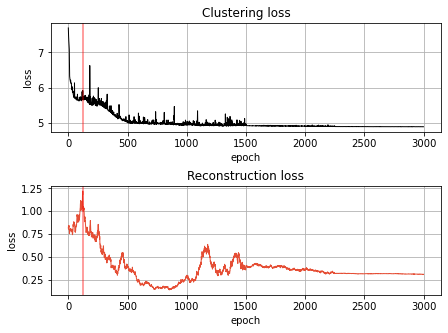

In [27]:
plot_loss(dir_summary, tag, epoch)

/home/lchuang/projects/scatnet/display.py:95: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  time = hf['time'].value
/home/lchuang/projects/scatnet/display.py:96: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  hot = hf['epoch_{:05d}'.format(epoch)]['hot'].value


[0 1 4 5 7 8 9]


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative within-clusters detections'}, ylabel='Number of events'>)

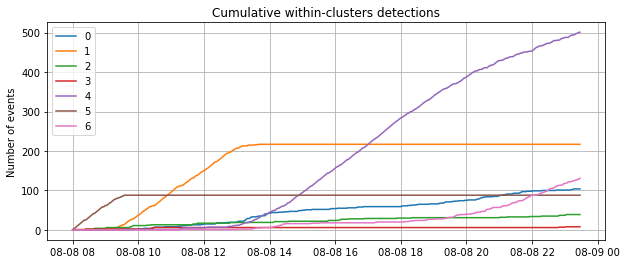

In [28]:
epoch = 120
show_detections(dir_summary, tag, epoch=epoch, dir_output=None,save='detections_{:05d}.png', norm=None)

/home/lchuang/projects/scatnet/display.py:145: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  latent = hf['epoch_{:05d}'.format(epoch)]['features'].value
/home/lchuang/projects/scatnet/display.py:146: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  means = hf['epoch_{:05d}'.format(epoch)]['means'].value
/home/lchuang/projects/scatnet/display.py:147: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  covariances = hf['epoch_{:05d}'.format(epoch)]['covariance'].value


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Scattering latent space'}, xlabel='First latent variable', ylabel='Second latent variable'>)

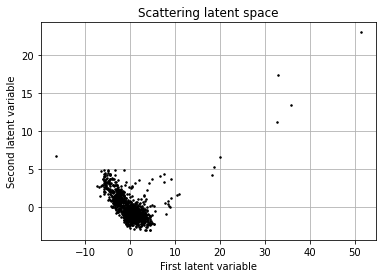

In [29]:
show_latent(dir_summary, tag, epoch=epoch, dir_output=None, save='latent.png')

/home/lchuang/projects/scatnet/display.py:257: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[0].set_yscale('log', basey=2)


(<Figure size 432x288 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'Graph time scales'}, ylabel='Patch shape'>,
        <AxesSubplot:xlabel='Layer index', ylabel='Frequency (Hz)'>], dtype=object))

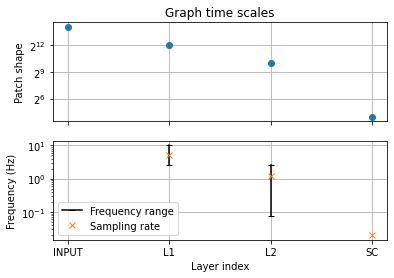

In [30]:
show_graph(dir_summary, tag, dir_output=None, save='graph.png')

In [31]:
def cluster_opt_to_pds(file_path):
    
    # ---- read in the h5py output file
    with h5py.File(file_path, 'r') as hf:
        time = hf['time'].value
        hot = hf['epoch_{:05d}'.format(epoch)]['hot'].value
    
    # ---- convert time format
    time_c = md.num2date(time)
    time_f = [UTCDateTime(t).datetime for t in time_c]
    
    # ---- conver them to a pd file
    pd_cluster = pd.DataFrame()
    pd_cluster["time"] = time_f
    pd_cluster["c_index"] = hot
    
    return pd_cluster

In [32]:
# Load cluster files
file_path = os.path.join(dir_summary, tag, 'clusters.h5')
pd_cluster = cluster_opt_to_pds(file_path)

/home/lchuang/anaconda/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """
/home/lchuang/anaconda/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [33]:
from obspy.signal.tf_misfit import plot_tfr

def plot_spectrogram(file, b_time, etime, appd_secs):
    
    # ---- read wf
    tr=read(file,starttime=b_time-appd_secs,endtime=etime+65+appd_secs)
    tr=tr.detrend('demean')
    tr=tr.filter('highpass',freq=0.1)
    
    # ---- plot spectrum and spectrogram
    for i in range(len(tr)):
        plot_tfr(tr[i].data, dt=tr[i].stats.delta, fmin=0.01, 
        fmax=10, w0=8., nf=64, fft_zero_pad_fac=4)   

In [34]:
cluster_index=1
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster

index                       time  c_index
0       64 2009-08-08 08:54:36.819500        1
1       65 2009-08-08 08:55:28.019500        1
2       73 2009-08-08 09:02:17.619500        1
3       90 2009-08-08 09:16:48.019500        1
4       92 2009-08-08 09:18:30.419500        1
5       95 2009-08-08 09:21:04.019500        1
6       96 2009-08-08 09:21:55.219500        1
7       97 2009-08-08 09:22:46.419500        1
8      100 2009-08-08 09:25:20.019500        1
9      101 2009-08-08 09:26:11.219500        1
10     103 2009-08-08 09:27:53.619500        1
11     106 2009-08-08 09:30:27.219500        1
12     107 2009-08-08 09:31:18.419500        1
13     111 2009-08-08 09:34:43.219500        1
14     112 2009-08-08 09:35:34.419500        1
15     113 2009-08-08 09:36:25.619500        1
16     114 2009-08-08 09:37:16.819500        1
17     115 2009-08-08 09:38:08.019500        1
18     116 2009-08-08 09:38:59.219500        1
19     117 2009-08-08 09:39:50.419500        1
20     118 2009-08-08 09:40:41.619500        1
21     119 2009-08-08 09:41:32.819500        1
22     120 2009-08-08 09:42:24.019500        1
23     121 2009-08-08 09:43:15.219500        1
24     124 2009-08-08 09:45:48.819500        1
25     125 2009-08-08 09:46:40.019500        1
26     126 2009-08-08 09:47:31.219500        1
27     130 2009-08-08 09:50:56.019500        1
28     131 2009-08-08 09:51:47.219500        1
29     132 2009-08-08 09:52:38.419500        1
..     ...                        ...      ...
187    324 2009-08-08 12:36:28.819500        1
188    325 2009-08-08 12:37:20.019500        1
189    326 2009-08-08 12:38:11.219500        1
190    327 2009-08-08 12:39:02.419500        1
191    328 2009-08-08 12:39:53.619500        1
192    329 2009-08-08 12:40:44.819500        1
193    330 2009-08-08 12:41:36.019500        1
194    333 2009-08-08 12:44:09.619500        1
195    335 2009-08-08 12:45:52.019500        1
196    336 2009-08-08 12:46:43.219500        1
197    339 2009-08-08 12:49:16.819500        1
198    340 2009-08-08 12:50:08.019500        1
199    341 2009-08-08 12:50:59.219500        1
200    342 2009-08-08 12:51:50.419500        1
201    343 2009-08-08 12:52:41.619500        1
202    346 2009-08-08 12:55:15.219500        1
203    347 2009-08-08 12:56:06.419500        1
204    348 2009-08-08 12:56:57.619500        1
205    349 2009-08-08 12:57:48.819500        1
206    350 2009-08-08 12:58:40.019500        1
207    356 2009-08-08 13:03:47.219500        1
208    357 2009-08-08 13:04:38.419500        1
209    358 2009-08-08 13:05:29.619500        1
210    361 2009-08-08 13:08:03.219500        1
211    362 2009-08-08 13:08:54.419500        1
212    364 2009-08-08 13:10:36.819500        1
213    375 2009-08-08 13:20:00.019500        1
214    376 2009-08-08 13:20:51.219500        1
215    391 2009-08-08 13:33:39.219500        1
216    399 2009-08-08 13:40:28.819500        1

[217 rows x 3 columns]

In [35]:
import plotly.graph_objs as go

# ---- plot Lin's catalog
lin_x, lin_y = make_cumus(pd_ls_catalog.time)
fig = go.Figure(data=[go.Scatter(x=lin_x,
                                 y=lin_y,
                                 marker=dict(
                                     size=pd_ls_catalog.mag**0.5*10,
                                     color=pd_ls_catalog.dist_to_sta,
                                     colorbar=dict(thickness=25,x=-0.15, len=0.8)
                                 ),
                                 text=pd_ls_catalog.dist_to_sta,
                                 mode='lines+markers',
                                 name='Lins')])
#fig = go.Figure()
# ---- plot clusters
for i in pd.unique(pd_cluster.c_index):
    if i != -9:
        clst_x, clst_y = make_cumus(pd_cluster[pd_cluster.c_index==i].time)
        fig.add_traces(data=[go.Scatter(x=clst_x, y=clst_y, mode='lines+markers',name=f'clst#{i}')])
    
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [36]:
def plot_align_clusters(cluster_idx, pd_cluster, wave_path, window_len, window_appd, align=False):
    # ---- extract cluster info
    pd_cluster = pd_cluster[pd_cluster.c_index==cluster_idx].reset_index()
    # ---- load waveform
    st=read(wave_path)
    st.detrend('linear')
    st.taper(max_percentage=0.005)
    #st.filter('highpass', freq=)
    sampling_rate = st[2].stats.sampling_rate
    st_start_time = st[2].stats.starttime
    
    # ---- numpy placeholder
    wave = []
    for i in range(len(pd_cluster)):
        offset_b_time = UTCDateTime(pd_cluster.iloc[i].time) - st_start_time - window_appd
        offset_e_time = offset_b_time + window_len + window_appd
        offset_b_sample = int(round(offset_b_time * sampling_rate))
        offset_e_sample = int(round(offset_e_time * sampling_rate))
        wv = st[2].data[offset_b_sample:offset_e_sample]
        wave.append(wv/max(abs(wv)))
        
    # ---- align waveform by ccc
    
    return np.asarray(wave), pd_cluster

In [37]:
from scipy import signal
import matplotlib.pyplot as plt

In [38]:
wv, pd_cst = plot_align_clusters(6, pd_cluster, wave_path, 65, 5)
#corr = signal.correlate(wv[48], wv[49], mode='same')
#fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
#ax_orig.plot(wv[48])
#ax_noise.plot(wv[49], 'r')
#ax_corr.plot(corr)
#ax_corr.axhline(0.5, ls=':')
#ax_corr.set_title('Cross-correlated with rectangular pulse')
#ax_orig.margins(0, 0.1)
#fig.tight_layout()
#plt.show()

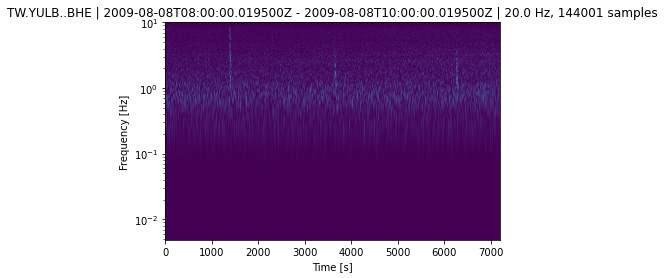

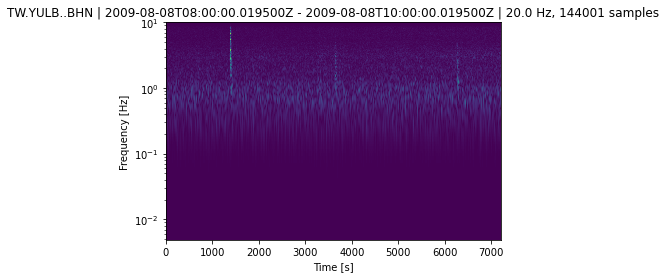

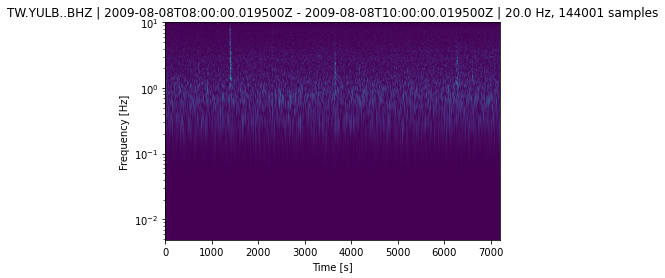

In [41]:
wave_path = wave_path
b_time = UTCDateTime(2009,8,8,8)
e_time = UTCDateTime(2009,8,8,10)
appd_secs=30
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path,starttime=b_time,endtime=e_time)\
.filter('highpass',freq=1)\
.spectrogram(log=True,dbscale=False,per_lap=0.95,wlen=10)

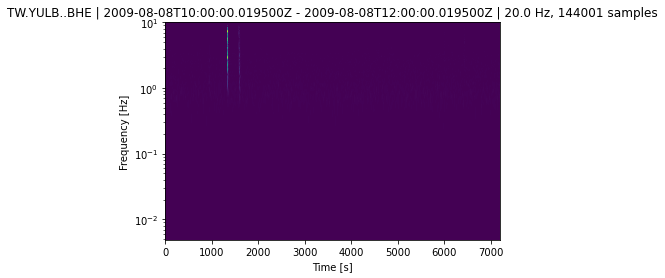

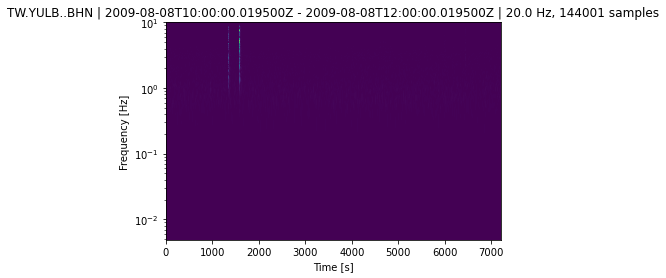

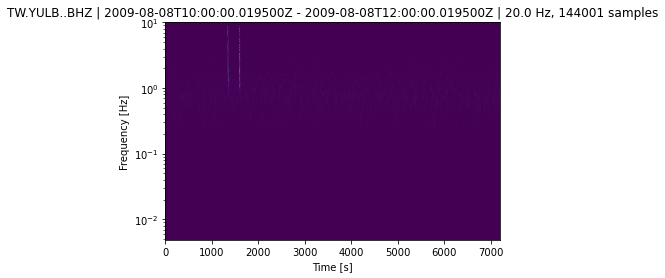

In [43]:
wave_path = wave_path
b_time = UTCDateTime(2009,8,8,10)
e_time = UTCDateTime(2009,8,8,12)
appd_secs=30
tr=read(wave_path,starttime=b_time,endtime=e_time)\
.filter('highpass',freq=1)\
.spectrogram(log=True,dbscale=False,per_lap=0.95,wlen=10)

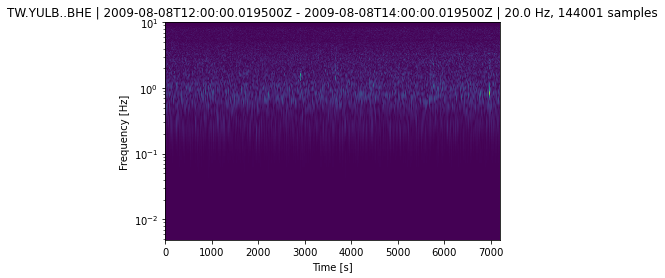

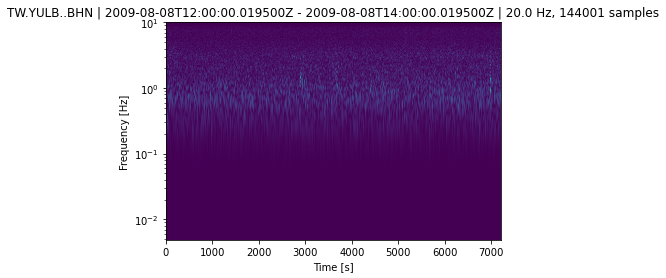

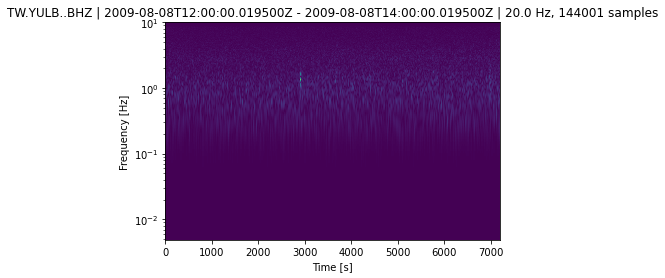

In [44]:
wave_path = wave_path
b_time = UTCDateTime(2009,8,8,12)
e_time = UTCDateTime(2009,8,8,14)
appd_secs=30
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path,starttime=b_time,endtime=e_time)\
.filter('highpass',freq=1)\
.spectrogram(log=True,dbscale=False,per_lap=0.95,wlen=10)

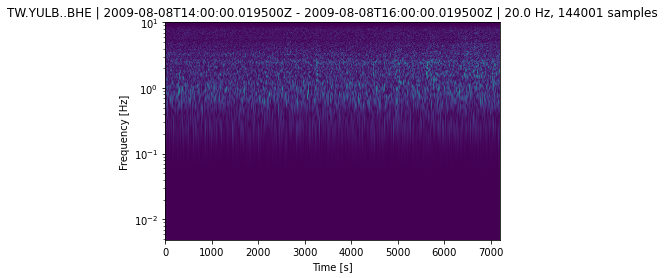

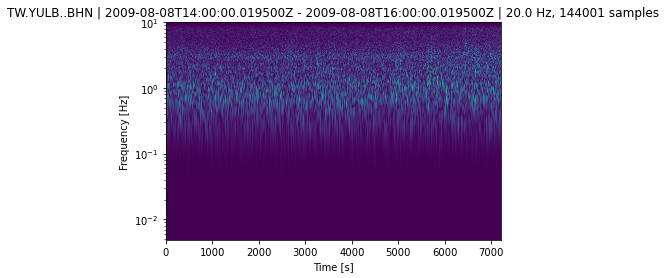

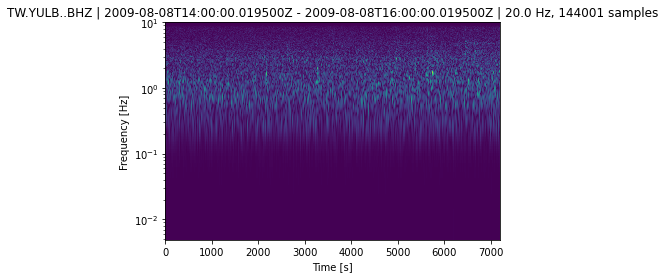

In [45]:
wave_path = wave_path
b_time = UTCDateTime(2009,8,8,14)
e_time = UTCDateTime(2009,8,8,16)
appd_secs=30
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path,starttime=b_time,endtime=e_time)\
.filter('highpass',freq=1)\
.spectrogram(log=True,dbscale=False,per_lap=0.95,wlen=10)

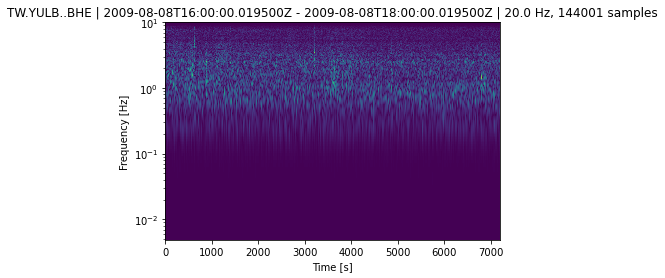

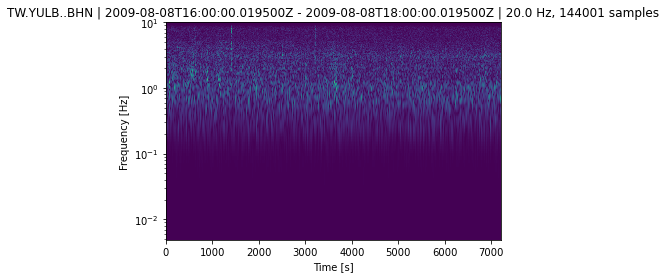

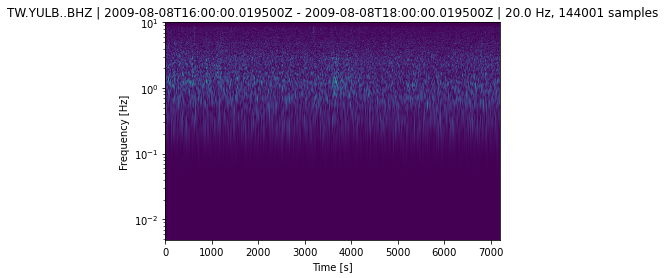

In [46]:
wave_path = wave_path
b_time = UTCDateTime(2009,8,8,16)
e_time = UTCDateTime(2009,8,8,18)
appd_secs=30
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path,starttime=b_time,endtime=e_time)\
.filter('highpass',freq=1)\
.spectrogram(log=True,dbscale=False,per_lap=0.95,wlen=10)

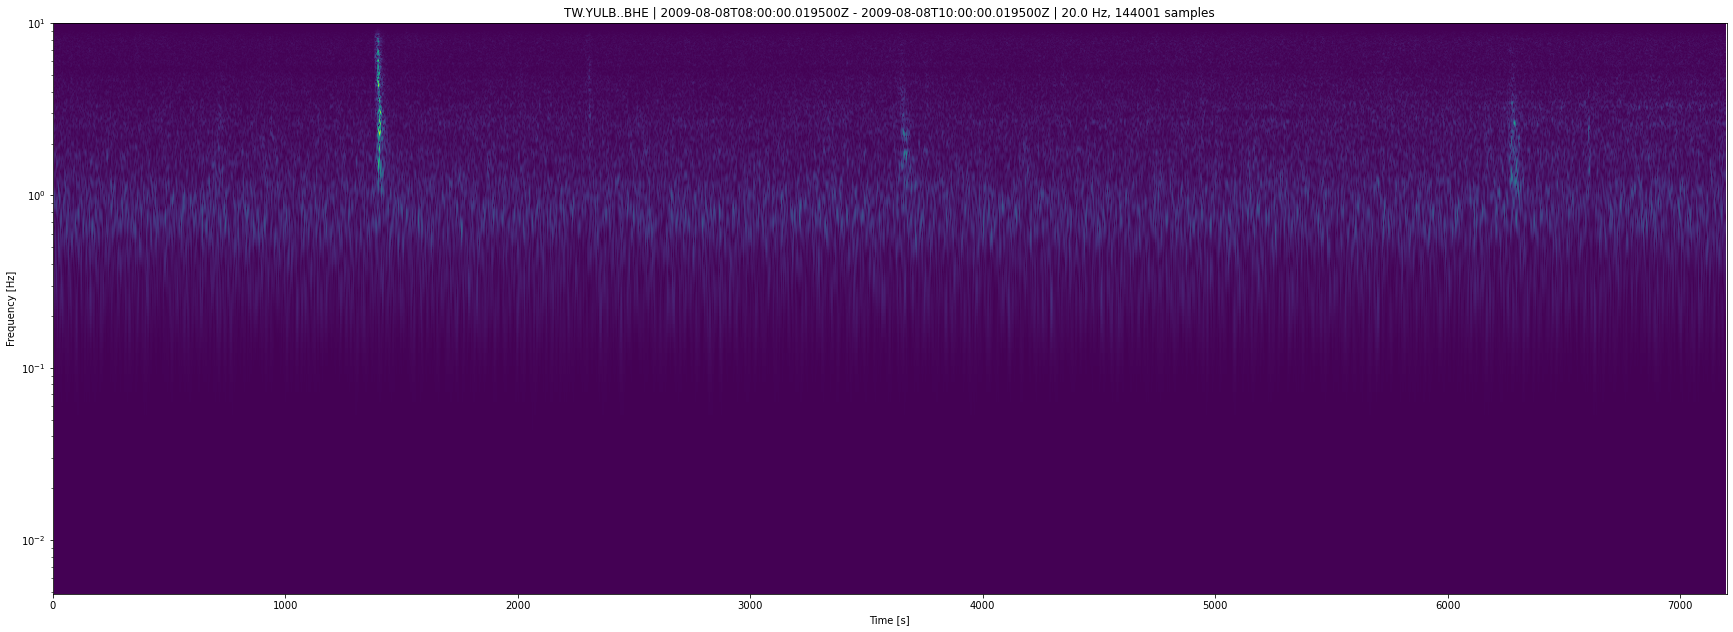

In [47]:
wave_path = wave_path
b_time = UTCDateTime(2009,8,8,8)
e_time = UTCDateTime(2009,8,8,10)
appd_secs=30
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path,starttime=b_time,endtime=e_time)\
.filter('highpass',freq=1)
fig=tr[0].spectrogram(log=True,dbscale=False,per_lap=0.95,wlen=10,show=False)
fig.set_size_inches(30, 10.5, forward=True)
fig.show()

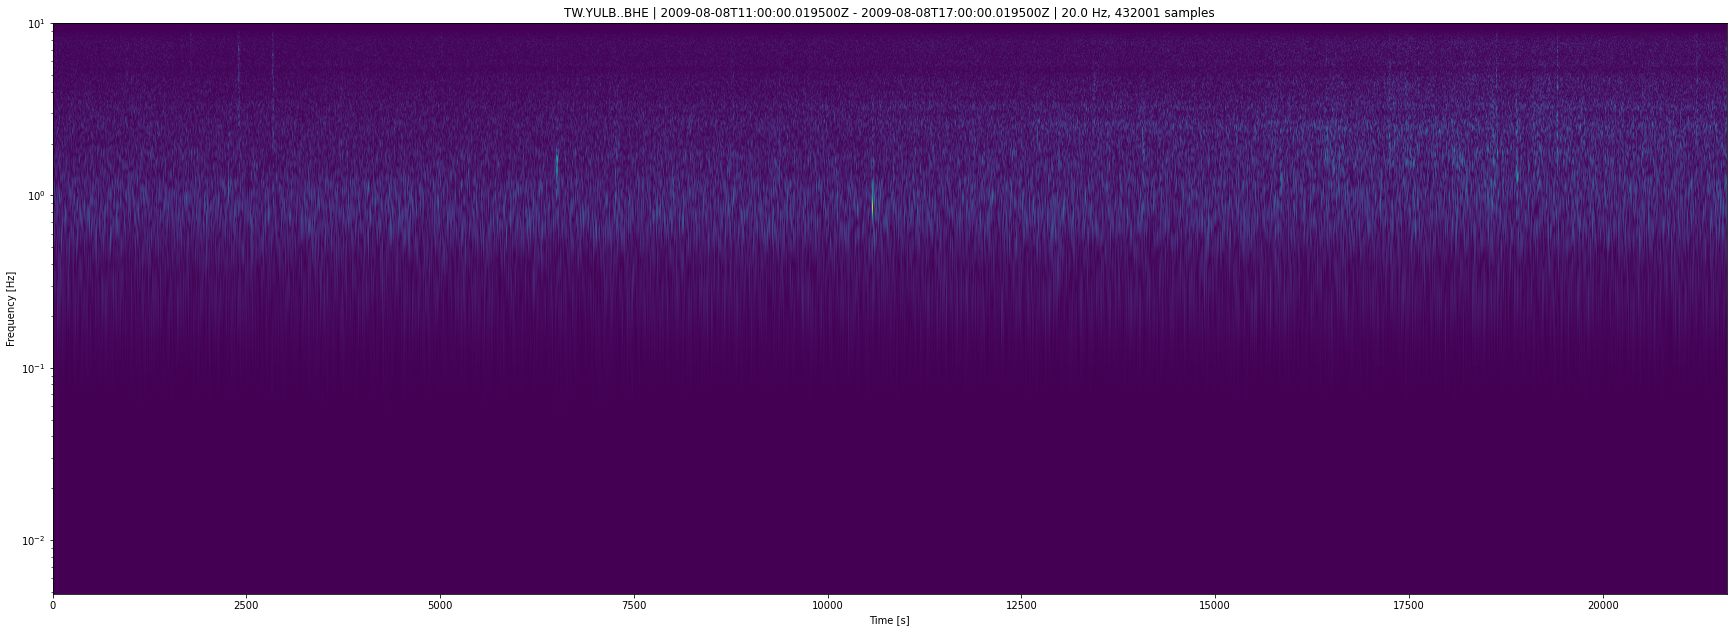

In [48]:
wave_path = wave_path
b_time = UTCDateTime(2009,8,8,11)
e_time = UTCDateTime(2009,8,8,17)
appd_secs=30
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path,starttime=b_time,endtime=e_time)\
.filter('highpass',freq=1)
fig=tr[0].spectrogram(log=True,dbscale=False,per_lap=0.95,wlen=10,show=False)
fig.set_size_inches(30, 10.5, forward=True)
fig.show()

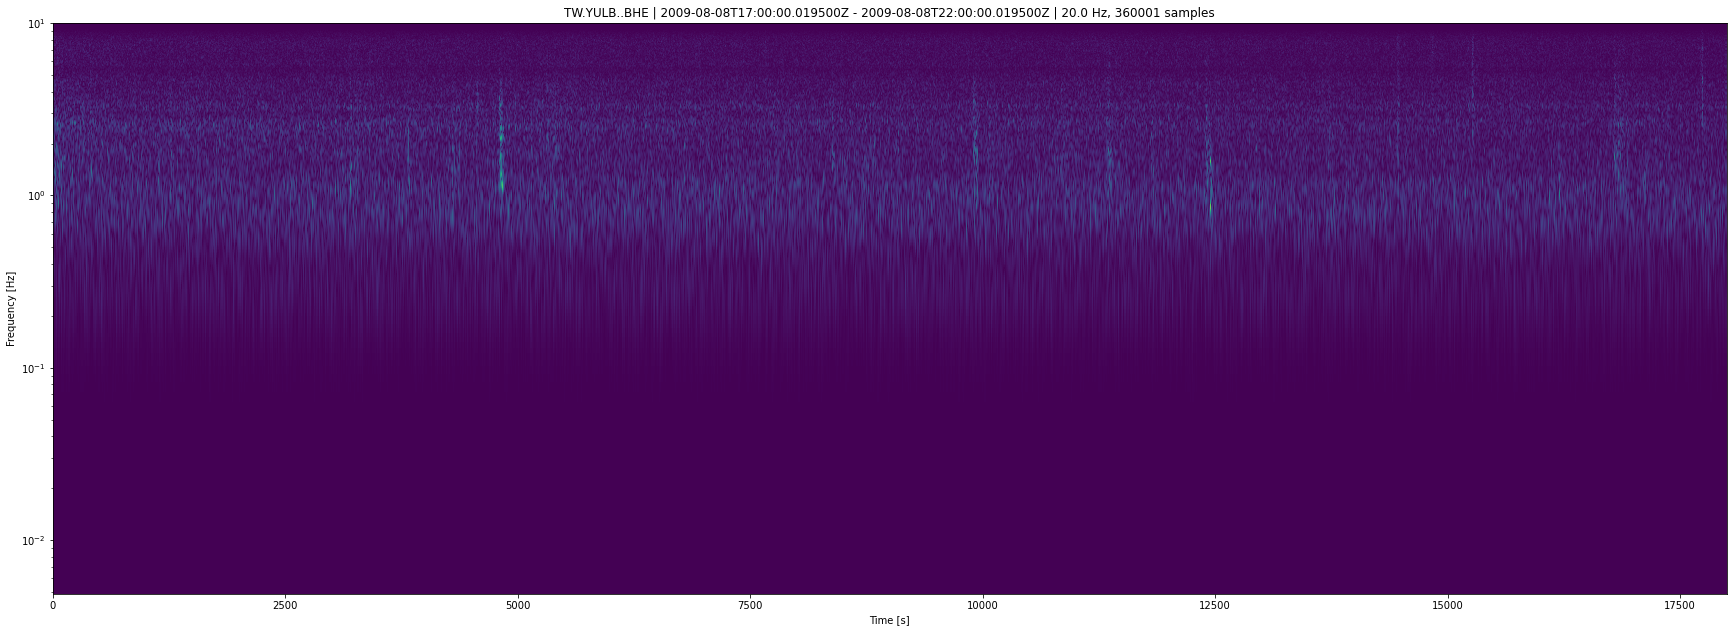

In [49]:
wave_path = wave_path
b_time = UTCDateTime(2009,8,8,17)
e_time = UTCDateTime(2009,8,8,22)
appd_secs=30
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path,starttime=b_time,endtime=e_time)\
.filter('highpass',freq=1)
fig=tr[0].spectrogram(log=True,dbscale=False,per_lap=0.95,wlen=10,show=False)
fig.set_size_inches(30, 10.5, forward=True)
fig.show()

In [50]:
e_time

2009-08-08T22:00:00.000000Z

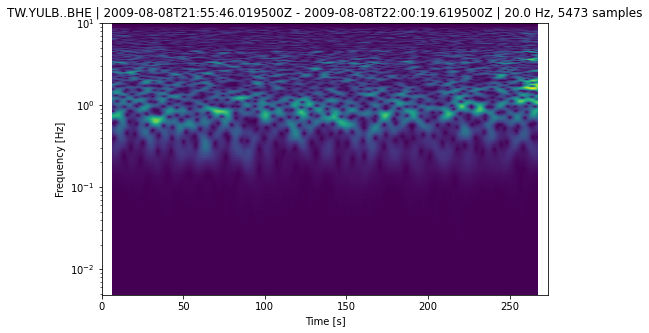

In [51]:
cluster_index=9
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
wave_path = wave_path
win_spec = 30
b_time = UTCDateTime(spec_cluster.iloc[84].time) - win_spec
#e_time = b_time + 2 * win_spec + 60
e_time = UTCDateTime(spec_cluster.iloc[87].time) + 60 + win_spec

tr=read(wave_path,starttime=b_time,endtime=e_time)\
.filter('highpass',freq=1)
fig=tr[0].spectrogram(log=True,dbscale=False,per_lap=0.99,wlen=10,show=False)
fig.set_size_inches(8, 5, forward=True)
fig.show()

In [52]:
cluster_index=5
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[4].time)
e_time = UTCDateTime(spec_cluster.iloc[10].time)
#appd_secs=30
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
#tr=read(wave_path, starttime=b_time,endtime=e_time).spectrogram(log=True)

IndexError: single positional indexer is out-of-bounds

In [ ]:
cluster_index=4
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[27].time)
e_time = UTCDateTime(spec_cluster.iloc[27].time)
#appd_secs=30
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
#tr=read(wave_path, starttime=b_time,endtime=e_time).spectrogram(log=True)

In [ ]:
cluster_index=4
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[42].time)
e_time = UTCDateTime(spec_cluster.iloc[42].time)
appd_secs=30
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
#tr=read(wave_path, starttime=b_time,endtime=e_time).spectrogram(log=True)

In [ ]:
cluster_index=4
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[39].time)
e_time = UTCDateTime(spec_cluster.iloc[41].time)
appd_secs=30
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
#tr=read(wave_path, starttime=b_time,endtime=e_time).spectrogram(log=True)

In [ ]:
cluster_index=0
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[131].time)
e_time = UTCDateTime(spec_cluster.iloc[135].time)
#appd_secs=30
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
#tr=read(wave_path, starttime=b_time,endtime=e_time).spectrogram(log=True)

In [ ]:
cluster_index=1
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[5].time)
e_time = UTCDateTime(spec_cluster.iloc[252].time)
#appd_secs=60
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path, starttime=b_time,endtime=e_time).spectrogram(log=True)

In [ ]:
cluster_index=9
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[102].time)
e_time = UTCDateTime(spec_cluster.iloc[343].time)
#appd_secs=30
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path, starttime=b_time,endtime=e_time).spectrogram(log=True)

In [ ]:
cluster_index=7
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[1].time)
e_time = UTCDateTime(spec_cluster.iloc[177].time)
#appd_secs=30
#plot_spectrogram(wave_path, b_time, e_time, appd_secs) 
tr=read(wave_path, starttime=b_time,endtime=e_time).spectrogram(log=True)

In [ ]:
cluster_index=2
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[2].time)
e_time = UTCDateTime(spec_cluster.iloc[2].time)
appd_secs=60
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 

### classified as landslide (cluster 2) but not in Lin's catalog

In [ ]:
cluster_index=2
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[12].time)
e_time = UTCDateTime(spec_cluster.iloc[13].time)
appd_secs=60
plot_spectrogram(wave_path, b_time, e_time, appd_secs)  

In [ ]:
cluster_index=2
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[16].time)
e_time = UTCDateTime(spec_cluster.iloc[17].time)
appd_secs=60
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 

### Landslide classified as EQ 

In [ ]:
cluster_index=1
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[18].time)
e_time = UTCDateTime(spec_cluster.iloc[21].time)
appd_secs=60
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 

In [ ]:
cluster_index=1
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[14].time)
e_time = UTCDateTime(spec_cluster.iloc[14].time)
appd_secs=60
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 

In [ ]:
cluster_index=1
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[12].time)
e_time = UTCDateTime(spec_cluster.iloc[12].time)
appd_secs=60
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 

### Earthquake classified as earthquake (cluster 1)

In [ ]:
cluster_index=1
spec_cluster = pd_cluster[pd_cluster.c_index==cluster_index].reset_index()
spec_cluster.head()
wave_path = wave_path
b_time = UTCDateTime(spec_cluster.iloc[1].time)
e_time = UTCDateTime(spec_cluster.iloc[1].time)
appd_secs=60
plot_spectrogram(wave_path, b_time, e_time, appd_secs) 